<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="right">


# Procesamiento de lenguaje natural


## TP4

### Alumno: Emmanuel Cardozo

## Ejercicio

Utilizar otro dataset y poner en práctica la predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./Ficciones', os.F_OK) is False:
    if os.access('Ficciones.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# Posibles bandas
os.listdir("./Ficciones/")

['El acercamiento de Almotasim.txt',
 'El fin.txt',
 'El jardin de los senderos que se bifurcan.txt',
 'El milagro secreto.txt',
 'El Sur.txt',
 'Examen de la obra de Herbert Quain.txt',
 'Funes el memorioso.txt',
 'La Biblioteca de Babel.txt',
 'La forma de la espada.txt',
 'La lotería en Babilonia.txt',
 'La muerte y la brujula.txt',
 'La secta del Fenix.txt',
 'Las ruinas circulares.txt',
 'Pierre Menard, autor del Quijote.txt',
 'Tema del traidor y del héroe.txt',
 'Tlon, Uqbar, Orbis Tertius.txt',
 'Tres versiones de Judas.txt']

In [45]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('Ficciones/Tlon, Uqbar, Orbis Tertius.txt', sep='/n', header=None)
df.head()

C:\Users\Emmanuel\AppData\Local\Temp\ipykernel_31360\4212807855.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('Ficciones/Tlon, Uqbar, Orbis Tertius.txt', sep='/n', header=None)


,0
0,"Tlén, Uqbar, Orbis Tertius"
1,Debo a la conjuncién de un espejo y de una enc...
2,espejo inquietaba el fondo de un corredor en u...
3,Mejia; la enciclopedia falazmente se llama The...
4,"1917) y es una reimpresion literal, pero tambi..."


In [46]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 434


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [47]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras_preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [48]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Tlén, Uqbar, Orbis Tertius'

In [49]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['tlén', 'uqbar', 'orbis', 'tertius']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [50]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [51]:
# Demos un vistazo
sentence_tokens[:2]

[['tlén', 'uqbar', 'orbis', 'tertius'],
 ['debo',
  'a',
  'la',
  'conjuncién',
  'de',
  'un',
  'espejo',
  'y',
  'de',
  'una',
  'enciclopedia',
  'el',
  'descubrimiento',
  'de',
  'uqbar',
  'el']]

In [52]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [53]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [54]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [55]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[]

In [56]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

0


In [57]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

0


In [58]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{}


In [59]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [60]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                            Tlén, Uqbar, Orbis Tertius
1     Debo a la conjuncién de un espejo y de una enc...
2     espejo inquietaba el fondo de un corredor en u...
3     Mejia; la enciclopedia falazmente se llama The...
4     1917) y es una reimpresion literal, pero tambi...
5     de 1902. El hecho se produjo hard unos cinco a...
6     esa noche y nos demor6 una vasta polémica sobr...
7     persona, cuyo narrador omitiera o desfigurara ...
8     contradicciones, que permitieran a unos pocos ...
9     adivinacién de una realidad atroz o banal. Des...
10    nos acechaba. Descubrimos (en la alta noche es...
11    espejos tienen algo monstruoso. Entonces Bioy ...
12    heresiarcas de Uqbar habia declarado que los e...
13    porque multiplican el numero de los hombres. L...
14    sentencia y me contest6 que The Anglo American...
15    articulo sobre Uqbar. La quinta (que habiamos ...
Name: 0, dtype: object

In [61]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

"Tlén, Uqbar, Orbis Tertius Debo a la conjuncién de un espejo y de una enciclopedia el descubrimiento de Uqbar. El espejo inquietaba el fondo de un corredor en una quinta de la calle Gaona, en Ramos Mejia; la enciclopedia falazmente se llama The Anglo American Cyclopaedia (Nueva York, 1917) y es una reimpresion literal, pero también morosa, de la Encyclopaedia Britannica de 1902. El hecho se produjo hard unos cinco afios. Bioy Casares habia cenado conmigo esa noche y nos demor6 una vasta polémica sobre la ejecucién de una novela en primera persona, cuyo narrador omitiera o desfigurara los hechos e incurriera en diversas contradicciones, que permitieran a unos pocos lectores -a muy pocos lectores- la adivinacién de una realidad atroz o banal. Desde el fondo remoto del corredor, el espejo nos acechaba. Descubrimos (en la alta noche ese descubrimiento es inevitable) que los espejos tienen algo monstruoso. Entonces Bioy Casares record6é que uno de los heresiarcas de Uqbar habia declarado q

In [62]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['tlén',
 'uqbar',
 'orbis',
 'tertius',
 'debo',
 'a',
 'la',
 'conjuncién',
 'de',
 'un',
 'espejo',
 'y',
 'de',
 'una',
 'enciclopedia',
 'el',
 'descubrimiento',
 'de',
 'uqbar',
 'el']

In [63]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 5742


In [64]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [65]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['tlén', 'uqbar', 'orbis', 'tertius'],
 ['uqbar', 'orbis', 'tertius', 'debo'],
 ['orbis', 'tertius', 'debo', 'a'],
 ['tertius', 'debo', 'a', 'la'],
 ['debo', 'a', 'la', 'conjuncién'],
 ['a', 'la', 'conjuncién', 'de'],
 ['la', 'conjuncién', 'de', 'un'],
 ['conjuncién', 'de', 'un', 'espejo'],
 ['de', 'un', 'espejo', 'y'],
 ['un', 'espejo', 'y', 'de'],
 ['espejo', 'y', 'de', 'una'],
 ['y', 'de', 'una', 'enciclopedia'],
 ['de', 'una', 'enciclopedia', 'el'],
 ['una', 'enciclopedia', 'el', 'descubrimiento'],
 ['enciclopedia', 'el', 'descubrimiento', 'de'],
 ['el', 'descubrimiento', 'de', 'uqbar'],
 ['descubrimiento', 'de', 'uqbar', 'el'],
 ['de', 'uqbar', 'el', 'espejo'],
 ['uqbar', 'el', 'espejo', 'inquietaba'],
 ['el', 'espejo', 'inquietaba', 'el']]

In [66]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[22, 40, 137, 113],
 [40, 137, 113, 558],
 [137, 113, 558, 9],
 [113, 558, 9, 2],
 [558, 9, 2, 559],
 [9, 2, 559, 1],
 [2, 559, 1, 7],
 [559, 1, 7, 187],
 [1, 7, 187, 5],
 [7, 187, 5, 1],
 [187, 5, 1, 13],
 [5, 1, 13, 46],
 [1, 13, 46, 3],
 [13, 46, 3, 188],
 [46, 3, 188, 1],
 [3, 188, 1, 40],
 [188, 1, 40, 3],
 [1, 40, 3, 187],
 [40, 3, 187, 560],
 [3, 187, 560, 3]]

In [67]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 5738


### 3 - Input y target

In [68]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [69]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [70]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [71]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(5738, 3)
(5738,)


In [72]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'el',
 4: 'que',
 5: 'y',
 6: 'en',
 7: 'un',
 8: 'los',
 9: 'a',
 10: 'es',
 11: 'del',
 12: 'no',
 13: 'una',
 14: 'las',
 15: 'con',
 16: 'se',
 17: 'lo',
 18: 'su',
 19: 'por',
 20: 'sus',
 21: 'o',
 22: 'tlén',
 23: 'ese',
 24: 'esa',
 25: 'mas',
 26: 'habia',
 27: 'era',
 28: 'son',
 29: 'pero',
 30: 'uno',
 31: 'al',
 32: 'dos',
 33: 'ha',
 34: 'han',
 35: 'hombres',
 36: 'me',
 37: 'como',
 38: 'hay',
 39: 'monedas',
 40: 'uqbar',
 41: 'otra',
 42: 'mundo',
 43: 'hecho',
 44: 'para',
 45: 'entre',
 46: 'enciclopedia',
 47: 'sobre',
 48: 'realidad',
 49: 'porque',
 50: 'obra',
 51: 'después',
 52: 'sido',
 53: 'también',
 54: 'unos',
 55: 'afios',
 56: 'bioy',
 57: 'nos',
 58: 'primera',
 59: 'muy',
 60: 'tal',
 61: 'yo',
 62: 'ya',
 63: 'tomo',
 64: 'todos',
 65: 'objetos',
 66: 'articulo',
 67: 'esas',
 68: 'ficciones',
 69: 'jorge',
 70: 'luis',
 71: 'borges',
 72: 'tres',
 73: 'sino',
 74: 'ahora',
 75: 'recuerdo',
 76: 'planeta',
 77: 'todo',
 78: 'o

In [73]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2078

In [74]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int-1, num_classes=vocab_size)

In [75]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [76]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(5738, 2078)

### 4 - Entrenar el modelo

In [77]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [78]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

2078

In [119]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 3, 5)              10395     
                                                                 
 lstm_35 (LSTM)              (None, 3, 64)             17920     
                                                                 
 dropout_24 (Dropout)        (None, 3, 64)             0         
                                                                 
 lstm_36 (LSTM)              (None, 64)                33024     
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 2078)              68574     
                                                                 
Total params: 131,993
Trainable params: 131,993
Non-t

In [120]:
hist = model.fit(x_data, y_data, epochs=500, validation_split=0.2)

Epoch 1/500
144/144 [==============================] - 11s 19ms/step - loss: 6.9613 - accuracy: 0.0508 - val_loss: 6.7422 - val_accuracy: 0.0767
Epoch 2/500
144/144 [==============================] - 2s 14ms/step - loss: 6.2771 - accuracy: 0.0656 - val_loss: 7.0110 - val_accuracy: 0.0767
Epoch 3/500
144/144 [==============================] - 2s 13ms/step - loss: 6.1991 - accuracy: 0.0656 - val_loss: 7.1941 - val_accuracy: 0.0767
Epoch 4/500
144/144 [==============================] - 2s 13ms/step - loss: 6.1453 - accuracy: 0.0656 - val_loss: 7.3908 - val_accuracy: 0.0767
Epoch 5/500
144/144 [==============================] - 2s 13ms/step - loss: 6.0775 - accuracy: 0.0656 - val_loss: 7.5090 - val_accuracy: 0.0767
Epoch 6/500
144/144 [==============================] - 2s 13ms/step - loss: 6.0279 - accuracy: 0.0660 - val_loss: 7.5624 - val_accuracy: 0.0767
Epoch 7/500
144/144 [==============================] - 2s 13ms/step - loss: 5.9644 - accuracy: 0.0660 - val_loss: 7.8852 - val_accuracy

144/144 [==============================] - 2s 13ms/step - loss: 4.4277 - accuracy: 0.0989 - val_loss: 14.6964 - val_accuracy: 0.0514
Epoch 58/500
144/144 [==============================] - 2s 13ms/step - loss: 4.4075 - accuracy: 0.0948 - val_loss: 14.6548 - val_accuracy: 0.0479
Epoch 59/500
144/144 [==============================] - 2s 13ms/step - loss: 4.3784 - accuracy: 0.0998 - val_loss: 14.9063 - val_accuracy: 0.0523
Epoch 60/500
144/144 [==============================] - 2s 13ms/step - loss: 4.3509 - accuracy: 0.0950 - val_loss: 14.8920 - val_accuracy: 0.0514
Epoch 61/500
144/144 [==============================] - 2s 13ms/step - loss: 4.3192 - accuracy: 0.1041 - val_loss: 15.1186 - val_accuracy: 0.0531
Epoch 62/500
144/144 [==============================] - 2s 14ms/step - loss: 4.3009 - accuracy: 0.1026 - val_loss: 15.5003 - val_accuracy: 0.0540
Epoch 63/500
144/144 [==============================] - 2s 13ms/step - loss: 4.2868 - accuracy: 0.1044 - val_loss: 15.3232 - val_accuracy

144/144 [==============================] - 2s 14ms/step - loss: 3.3256 - accuracy: 0.1680 - val_loss: 22.7671 - val_accuracy: 0.0488
Epoch 114/500
144/144 [==============================] - 2s 13ms/step - loss: 3.3284 - accuracy: 0.1671 - val_loss: 22.4865 - val_accuracy: 0.0453
Epoch 115/500
144/144 [==============================] - 2s 13ms/step - loss: 3.3214 - accuracy: 0.1667 - val_loss: 22.6886 - val_accuracy: 0.0427
Epoch 116/500
144/144 [==============================] - 2s 13ms/step - loss: 3.2919 - accuracy: 0.1647 - val_loss: 22.7326 - val_accuracy: 0.0462
Epoch 117/500
144/144 [==============================] - 2s 13ms/step - loss: 3.2659 - accuracy: 0.1730 - val_loss: 23.0971 - val_accuracy: 0.0497
Epoch 118/500
144/144 [==============================] - 2s 13ms/step - loss: 3.2522 - accuracy: 0.1704 - val_loss: 23.1688 - val_accuracy: 0.0453
Epoch 119/500
144/144 [==============================] - 2s 13ms/step - loss: 3.2455 - accuracy: 0.1745 - val_loss: 23.0327 - val_ac

Epoch 169/500
144/144 [==============================] - 2s 13ms/step - loss: 2.6697 - accuracy: 0.2756 - val_loss: 28.1508 - val_accuracy: 0.0375
Epoch 170/500
144/144 [==============================] - 2s 13ms/step - loss: 2.6729 - accuracy: 0.2625 - val_loss: 28.2774 - val_accuracy: 0.0340
Epoch 171/500
144/144 [==============================] - 2s 13ms/step - loss: 2.6691 - accuracy: 0.2717 - val_loss: 28.7865 - val_accuracy: 0.0357
Epoch 172/500
144/144 [==============================] - 2s 13ms/step - loss: 2.6288 - accuracy: 0.2706 - val_loss: 28.9057 - val_accuracy: 0.0383
Epoch 173/500
144/144 [==============================] - 2s 13ms/step - loss: 2.6237 - accuracy: 0.2765 - val_loss: 28.6615 - val_accuracy: 0.0383
Epoch 174/500
144/144 [==============================] - 2s 13ms/step - loss: 2.6277 - accuracy: 0.2771 - val_loss: 28.8848 - val_accuracy: 0.0314
Epoch 175/500
144/144 [==============================] - 2s 13ms/step - loss: 2.6239 - accuracy: 0.2874 - val_loss: 28

Epoch 225/500
144/144 [==============================] - 2s 14ms/step - loss: 2.1689 - accuracy: 0.3874 - val_loss: 33.3046 - val_accuracy: 0.0287
Epoch 226/500
144/144 [==============================] - 2s 14ms/step - loss: 2.1756 - accuracy: 0.3824 - val_loss: 33.1428 - val_accuracy: 0.0279
Epoch 227/500
144/144 [==============================] - 2s 13ms/step - loss: 2.1775 - accuracy: 0.3852 - val_loss: 33.4071 - val_accuracy: 0.0253
Epoch 228/500
144/144 [==============================] - 2s 13ms/step - loss: 2.1647 - accuracy: 0.3863 - val_loss: 33.5429 - val_accuracy: 0.0322
Epoch 229/500
144/144 [==============================] - 2s 13ms/step - loss: 2.1630 - accuracy: 0.3865 - val_loss: 33.2214 - val_accuracy: 0.0322
Epoch 230/500
144/144 [==============================] - 2s 14ms/step - loss: 2.1335 - accuracy: 0.3856 - val_loss: 33.6183 - val_accuracy: 0.0279
Epoch 231/500
144/144 [==============================] - 2s 14ms/step - loss: 2.1412 - accuracy: 0.3946 - val_loss: 33

Epoch 281/500
144/144 [==============================] - 2s 14ms/step - loss: 1.8035 - accuracy: 0.4710 - val_loss: 36.4178 - val_accuracy: 0.0270
Epoch 282/500
144/144 [==============================] - 2s 14ms/step - loss: 1.8043 - accuracy: 0.4739 - val_loss: 36.7900 - val_accuracy: 0.0314
Epoch 283/500
144/144 [==============================] - 2s 14ms/step - loss: 1.8274 - accuracy: 0.4632 - val_loss: 36.5045 - val_accuracy: 0.0253
Epoch 284/500
144/144 [==============================] - 2s 14ms/step - loss: 1.8255 - accuracy: 0.4712 - val_loss: 36.8747 - val_accuracy: 0.0314
Epoch 285/500
144/144 [==============================] - 2s 14ms/step - loss: 1.8211 - accuracy: 0.4747 - val_loss: 36.9071 - val_accuracy: 0.0270
Epoch 286/500
144/144 [==============================] - 2s 14ms/step - loss: 1.8007 - accuracy: 0.4730 - val_loss: 36.7979 - val_accuracy: 0.0209
Epoch 287/500
144/144 [==============================] - 2s 14ms/step - loss: 1.7812 - accuracy: 0.4946 - val_loss: 37

Epoch 337/500
144/144 [==============================] - 2s 14ms/step - loss: 1.5513 - accuracy: 0.5410 - val_loss: 39.8300 - val_accuracy: 0.0235
Epoch 338/500
144/144 [==============================] - 2s 15ms/step - loss: 1.5764 - accuracy: 0.5532 - val_loss: 40.0517 - val_accuracy: 0.0279
Epoch 339/500
144/144 [==============================] - 2s 14ms/step - loss: 1.5202 - accuracy: 0.5580 - val_loss: 39.4259 - val_accuracy: 0.0253
Epoch 340/500
144/144 [==============================] - 2s 14ms/step - loss: 1.5524 - accuracy: 0.5423 - val_loss: 39.7766 - val_accuracy: 0.0279
Epoch 341/500
144/144 [==============================] - 2s 14ms/step - loss: 1.5324 - accuracy: 0.5547 - val_loss: 40.0326 - val_accuracy: 0.0270
Epoch 342/500
144/144 [==============================] - 2s 14ms/step - loss: 1.5061 - accuracy: 0.5562 - val_loss: 39.5395 - val_accuracy: 0.0296
Epoch 343/500
144/144 [==============================] - 2s 15ms/step - loss: 1.5332 - accuracy: 0.5473 - val_loss: 40

Epoch 393/500
144/144 [==============================] - 2s 14ms/step - loss: 1.3478 - accuracy: 0.6041 - val_loss: 41.5137 - val_accuracy: 0.0253
Epoch 394/500
144/144 [==============================] - 2s 14ms/step - loss: 1.3756 - accuracy: 0.5943 - val_loss: 41.6282 - val_accuracy: 0.0296
Epoch 395/500
144/144 [==============================] - 2s 14ms/step - loss: 1.3580 - accuracy: 0.6020 - val_loss: 41.7060 - val_accuracy: 0.0253
Epoch 396/500
144/144 [==============================] - 2s 14ms/step - loss: 1.3440 - accuracy: 0.6100 - val_loss: 42.3603 - val_accuracy: 0.0244
Epoch 397/500
144/144 [==============================] - 2s 14ms/step - loss: 1.3132 - accuracy: 0.6129 - val_loss: 41.9299 - val_accuracy: 0.0261
Epoch 398/500
144/144 [==============================] - 2s 14ms/step - loss: 1.3491 - accuracy: 0.6031 - val_loss: 41.8159 - val_accuracy: 0.0244
Epoch 399/500
144/144 [==============================] - 2s 14ms/step - loss: 1.3525 - accuracy: 0.6048 - val_loss: 41

Epoch 449/500
144/144 [==============================] - 2s 14ms/step - loss: 1.1996 - accuracy: 0.6434 - val_loss: 43.3488 - val_accuracy: 0.0261
Epoch 450/500
144/144 [==============================] - 2s 14ms/step - loss: 1.1923 - accuracy: 0.6525 - val_loss: 43.1811 - val_accuracy: 0.0244
Epoch 451/500
144/144 [==============================] - 2s 14ms/step - loss: 1.1934 - accuracy: 0.6410 - val_loss: 43.6225 - val_accuracy: 0.0261
Epoch 452/500
144/144 [==============================] - 2s 14ms/step - loss: 1.2428 - accuracy: 0.6336 - val_loss: 44.0825 - val_accuracy: 0.0296
Epoch 453/500
144/144 [==============================] - 2s 14ms/step - loss: 1.1917 - accuracy: 0.6547 - val_loss: 43.4728 - val_accuracy: 0.0279
Epoch 454/500
144/144 [==============================] - 2s 14ms/step - loss: 1.1943 - accuracy: 0.6475 - val_loss: 43.2811 - val_accuracy: 0.0253
Epoch 455/500
144/144 [==============================] - 2s 14ms/step - loss: 1.2399 - accuracy: 0.6301 - val_loss: 43

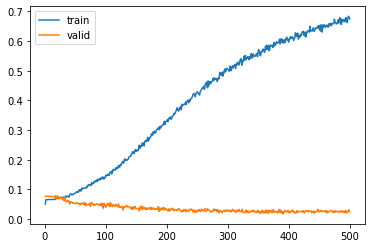

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [122]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [123]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [124]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

C:\Users\Emmanuel\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 20ms/step
Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x291c62b5d20>, 'http://127.0.0.1:7860/', None)

### 6 - Generación de secuencias nuevas

In [127]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [153]:
input_text='esas refutaciones no resultaron'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 24ms/step


'esas refutaciones no resultaron resultaron conjetura'

In [154]:
input_text='refiere a los idiomas del'

generate_seq(model, tok, input_text, max_length=4, n_words=2)

1/1 [==============================] - 0s 22ms/step


'refiere a los idiomas del islas cualquiera'

In [161]:
input_text='universo como una serie de procesos'

generate_seq(model, tok, input_text, max_length=3, n_words=2)


1/1 [==============================] - 0s 20ms/step


'universo como una serie de procesos procesos nuestra'

In [168]:
input_text='Leimos con algun cuidado el'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 20ms/step


'Leimos con algun cuidado el objetos la'

### 7 - Conclusiones
El modelo entrenado tuvo un muy mejor desempeño que en el caso visto en clase, en parte debido al agregado de más epochs a la RNN, aunque a la hora de predecir, las palabras no tienen relación directa con el resto de la oración propuesta.

También destacaremos la menor cantidad de datos entrenados, teniendo en cuenta que el corpus se compone de una menor cantidad de texto, con lo que el entrenamiento resulta un tanto escaso.

Finalmente: Se probaron varias combinaciones de capas y valores distintos de dropout entre ellas, sin embargo se volvió al modelo original con 1 sola capa hidden, y con un dropout de 0.6 (originalmente se encontraba en 0.2).